In [ ]:

# importing utilities
import os
import sys
from datetime import datetime

# importing data science libraries
import pandas as pd
import random as rd
import numpy as np

# importing pytorch libraries
import torch
from torch import nn
from torch import autograd
from torch.utils.data import DataLoader

# import visualization libraries
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from IPython.display import Image, display
sns.set_style('darkgrid')

# ignore potential warnings
import warnings
warnings.filterwarnings("ignore")

# Allow for Jupyter notebook inline plotting:
%matplotlib inline

In [ ]:
# print CUDNN backend version
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] The CUDNN backend version: {}'.format(now, torch.backends.cudnn.version()))

[LOG 20241013-03:48:47] The CUDNN backend version: 90100


In [ ]:
# If CUDNN and GPU's are available let's still specify if we want to use both:
USE_CUDA = True

In [ ]:
# print current Python version
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] The Python version: {}'.format(now, sys.version))

[LOG 20241013-03:48:47] The Python version: 3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]


In [ ]:
# print current PyTorch version
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] The PyTorch version: {}'.format(now, torch.__version__))

[LOG 20241013-03:48:47] The PyTorch version: 2.4.1+cu121


In [ ]:
# init deterministic seed
seed_value = 1234 #4444 #3333 #2222 #1111 #1234
rd.seed(seed_value) # set random seed
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU
if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    torch.cuda.manual_seed(seed_value) # set pytorch seed GPU

In [ ]:
ori_dataset = pd.read_csv('Anomaly_dataset.csv')
ori_dataset.head()

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
0,288203,C3,C31,C9,C92,A3,B1,280979.60,0.00,regular
1,324441,C1,C18,C7,C76,A1,B2,129856.53,243343.00,regular
2,133537,C1,C19,C2,C20,A1,B3,957463.97,3183838.41,regular
3,331521,C4,C48,C9,C95,A2,B1,2681709.51,28778.00,regular
4,375333,C5,C58,C1,C19,A3,B1,910514.49,346.00,regular


In [ ]:
# inspect the datasets dimensionalities
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] Transactional dataset of {} rows and {} columns loaded'.format(now, ori_dataset.shape[0], ori_dataset.shape[1]))

[LOG 20241013-03:48:48] Transactional dataset of 533009 rows and 10 columns loaded


In [ ]:
# inspect top rows of dataset
ori_dataset.head(10)

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
0,288203,C3,C31,C9,C92,A3,B1,280979.60,0.00,regular
1,324441,C1,C18,C7,C76,A1,B2,129856.53,243343.00,regular
2,133537,C1,C19,C2,C20,A1,B3,957463.97,3183838.41,regular
3,331521,C4,C48,C9,C95,A2,B1,2681709.51,28778.00,regular
4,375333,C5,C58,C1,C19,A3,B1,910514.49,346.00,regular
5,327203,C1,C15,C6,C68,A1,B2,357627.56,704520.00,regular
6,292545,C4,C47,C2,C28,A2,B3,955576.84,128328.00,regular
7,335839,C1,C19,C1,C17,A1,B1,41769.26,0.00,regular
8,369064,C4,C40,C9,C97,A2,B1,44309.79,0.00,regular
9,138724,C6,C69,C1,C12,A2,B1,466720.45,43843.00,regular


In [ ]:
# number of anomalies vs. regular transactions
ori_dataset.label.value_counts()

,count
label,
regular,532909
global,70
local,30


In [ ]:
# remove the "ground-truth" label information for the following steps of the lab
label = ori_dataset.pop('label')

In [ ]:
# inspect top rows of dataset
ori_dataset.head(10)

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR
0,288203,C3,C31,C9,C92,A3,B1,280979.60,0.00
1,324441,C1,C18,C7,C76,A1,B2,129856.53,243343.00
2,133537,C1,C19,C2,C20,A1,B3,957463.97,3183838.41
3,331521,C4,C48,C9,C95,A2,B1,2681709.51,28778.00
4,375333,C5,C58,C1,C19,A3,B1,910514.49,346.00
5,327203,C1,C15,C6,C68,A1,B2,357627.56,704520.00
6,292545,C4,C47,C2,C28,A2,B3,955576.84,128328.00
7,335839,C1,C19,C1,C17,A1,B1,41769.26,0.00
8,369064,C4,C40,C9,C97,A2,B1,44309.79,0.00
9,138724,C6,C69,C1,C12,A2,B1,466720.45,43843.00


Text(0.5, 1.0, 'Distribution of HKONT attribute values')

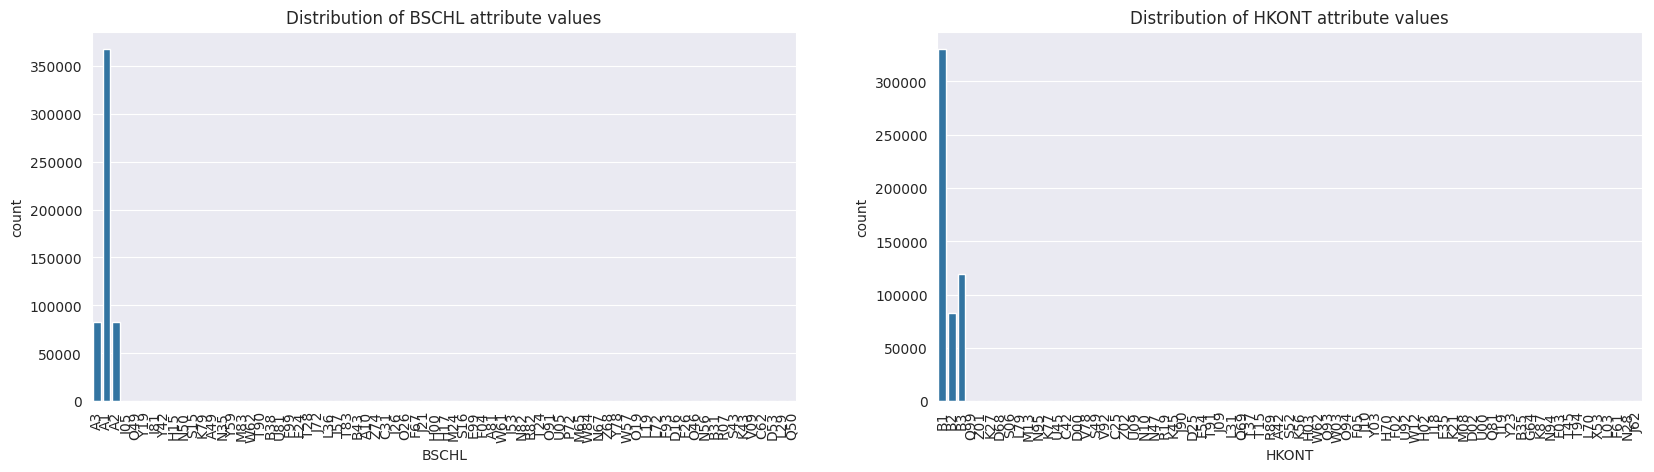

In [ ]:
# prepare to plot posting key and general ledger account side by side
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)

# plot the distribution of the posting key attribute
g = sns.countplot(x=ori_dataset['BSCHL'], ax=ax[0])
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Distribution of BSCHL attribute values')

# plot the distribution of the general ledger account attribute
g = sns.countplot(x=ori_dataset['HKONT'], ax=ax[1])
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Distribution of HKONT attribute values')

In [ ]:
# select categorical attributes to be "one-hot" encoded
categorical_attr_names = ['KTOSL', 'PRCTR', 'BSCHL', 'HKONT','WAERS', 'BUKRS']

# encode categorical attributes into a binary one-hot encoded representation
ori_dataset_categ_transformed = pd.get_dummies(ori_dataset[categorical_attr_names])

In [ ]:
# inspect encoded sample transactions
ori_dataset_categ_transformed.head(10)

,KTOSL_A19,KTOSL_B06,KTOSL_B12,KTOSL_B83,KTOSL_C1,KTOSL_C2,KTOSL_C3,KTOSL_C39,KTOSL_C4,KTOSL_C5,...,BUKRS_W67,BUKRS_W69,BUKRS_W71,BUKRS_W77,BUKRS_W86,BUKRS_X34,BUKRS_Y41,BUKRS_Y63,BUKRS_Z78,BUKRS_Z98
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## **Pre processing of Numerical transactions attributes**

Text(0.5, 1.0, 'Distribution of WRBTR amount values')

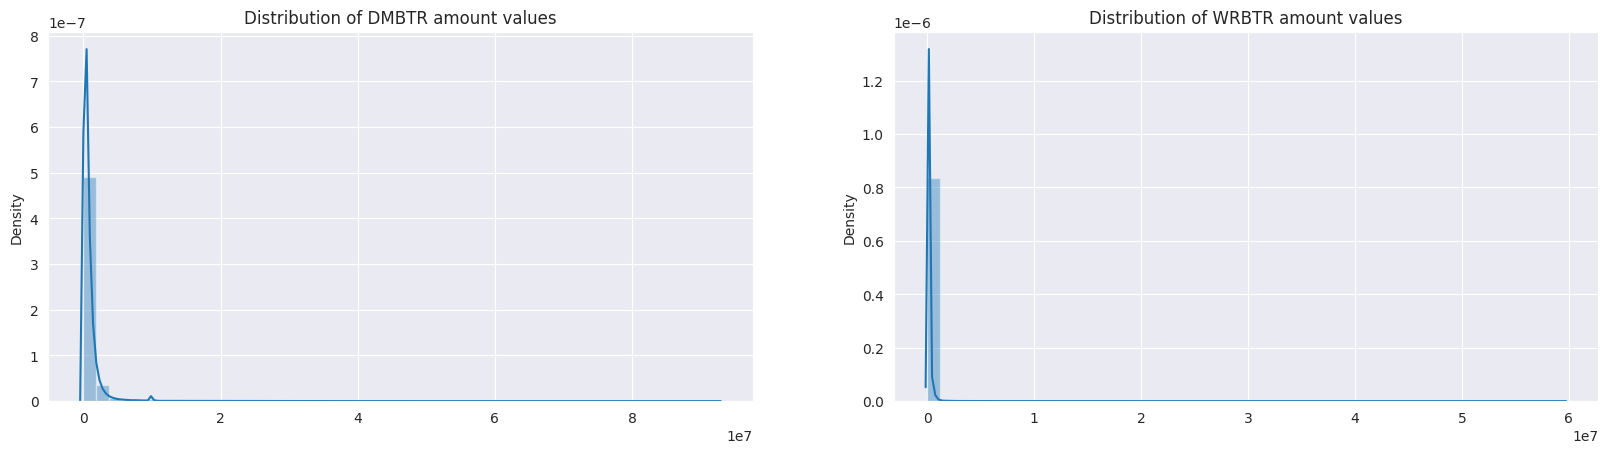

In [ ]:
# plot the log-scaled "DMBTR" as well as the "WRBTR" attribute value distribution
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)

# plot distribution of the local amount attribute
g = sns.distplot(ori_dataset['DMBTR'].tolist(), ax=ax[0])
g.set_title('Distribution of DMBTR amount values')

# plot distribution of the document amount attribute
g = sns.distplot(ori_dataset['WRBTR'].tolist(), ax=ax[1])
g.set_title('Distribution of WRBTR amount values')

In [ ]:
# select "DMBTR" vs. "WRBTR" attribute
numeric_attr_names = ['DMBTR', 'WRBTR']

# add a small epsilon to eliminate zero values from data for log scaling
numeric_attr = ori_dataset[numeric_attr_names] + 1e-7
numeric_attr = numeric_attr.apply(np.log)

# normalize all numeric attributes to the range [0,1]
ori_dataset_numeric_attr = (numeric_attr - numeric_attr.min()) / (numeric_attr.max() - numeric_attr.min())

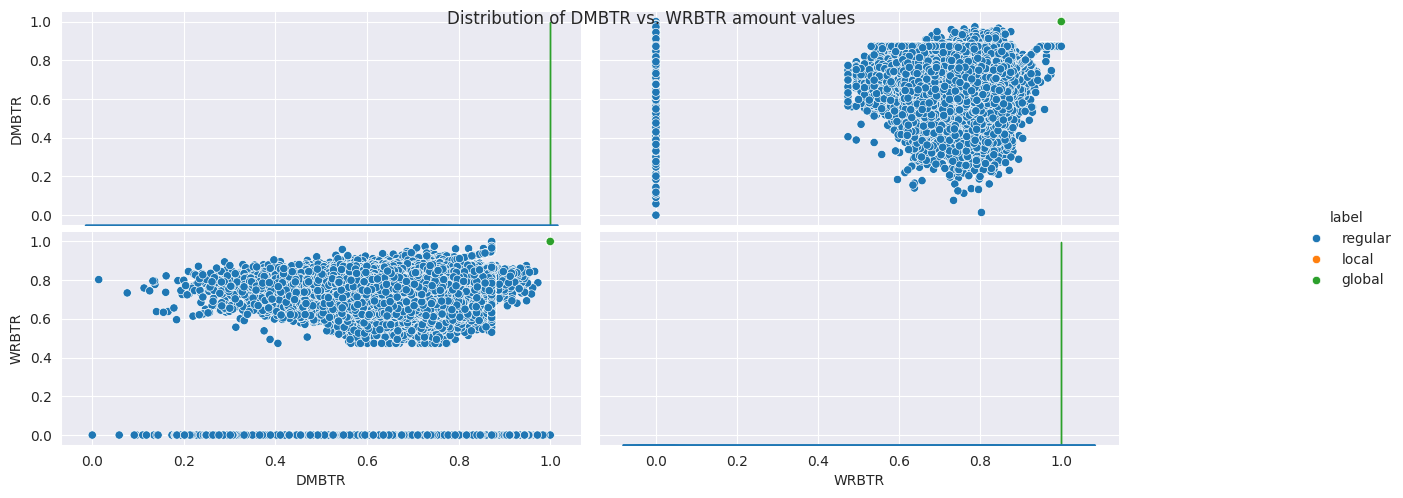

In [ ]:
# append 'label' attribute for colour distinction
numeric_attr_vis = ori_dataset_numeric_attr.copy()
numeric_attr_vis['label'] = label

# plot the log-scaled and min-max normalized numeric attributes
g = sns.pairplot(data=numeric_attr_vis, vars=numeric_attr_names, hue='label')
g.fig.suptitle('Distribution of DMBTR vs. WRBTR amount values')
g.fig.set_size_inches(15, 5)

In [ ]:
# merge categorical and numeric subsets
ori_subset_transformed = pd.concat([ori_dataset_categ_transformed, ori_dataset_numeric_attr], axis = 1)


In [ ]:
# inspect final dimensions of pre-processed transactional data
# ori_subset_transformed = ori_subset_transformed.sample(frac=0.50)
ori_subset_transformed.shape

(533009, 618)

In [ ]:
import gc

gc.collect()

584

# AUTOENCODER NEURAL NETWORKS

In [ ]:
import torch
import torch.nn as nn
# implementation of the shallow encoder network
# containing only a single layer

class encoder(nn.Module):

    def __init__(self):

        super(encoder, self).__init__()

        # specify layer 1 - in 618, out 3
        self.encoder_L1 = nn.Linear(in_features=ori_subset_transformed.shape[1], out_features=3, bias=True) # add linearity
        nn.init.xavier_uniform_(self.encoder_L1.weight) # init weights according to [9]
        self.encoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

    def forward(self, x):

        # define forward pass through the network
        x = self.encoder_R1(self.encoder_L1(x)) # don't apply dropout to the AE bottleneck

        return x

In [ ]:
# init training network classes / architectures
encoder_train = encoder()

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    encoder_train = encoder().cuda()

In [ ]:
# print the initialized architectures
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] encoder architecture:\n\n{}\n'.format(now, encoder_train))

[LOG 20241013-03:50:46] encoder architecture:

encoder(
  (encoder_L1): Linear(in_features=618, out_features=3, bias=True)
  (encoder_R1): LeakyReLU(negative_slope=0.4, inplace=True)
)



In [ ]:
# implementation of the shallow decoder network
# containing only a single layer
class decoder(nn.Module):

    def __init__(self):

        super(decoder, self).__init__()

        # specify layer 1 - in 3, out 618
        self.decoder_L1 = nn.Linear(in_features=3, out_features=ori_subset_transformed.shape[1], bias=True) # add linearity
        nn.init.xavier_uniform_(self.decoder_L1.weight)  # init weights according to [9]
        self.decoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

    def forward(self, x):

        # define forward pass through the network
        x = self.decoder_R1(self.decoder_L1(x)) # don't apply dropout to the AE output

        return x


In [ ]:
# init training network classes / architectures
decoder_train = decoder()

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
    decoder_train = decoder().cuda()

# print the initialized architectures
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] decoder architecture:\n\n{}\n'.format(now, decoder_train))

[LOG 20241013-03:50:46] decoder architecture:

decoder(
  (decoder_L1): Linear(in_features=3, out_features=618, bias=True)
  (decoder_R1): LeakyReLU(negative_slope=0.4, inplace=True)
)



# AUTOENCODER TRAINING

In [ ]:
# define the optimization criterion / loss function
loss_function = nn.BCEWithLogitsLoss(reduction='mean')

In [ ]:
# define learning rate and optimization strategy
learning_rate = 1e-3
encoder_optimizer = torch.optim.Adam(encoder_train.parameters(), lr=learning_rate)
decoder_optimizer = torch.optim.Adam(decoder_train.parameters(), lr=learning_rate)

In [ ]:
# specify training parameters
num_epochs = 5
mini_batch_size = 128

In [ ]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import pandas as pd # Import pandas

# Assuming ori_subset_transformed is your pandas DataFrame

# Convert all columns to numeric dtype, handling errors as needed
# You might need to adjust the 'errors' argument based on how you want to handle invalid values
numeric_df = ori_subset_transformed.apply(pd.to_numeric, errors='coerce')

# Explicitly convert to a supported dtype before creating the tensor
# Choose float32 or float64 based on your needs
torch_dataset = torch.from_numpy(numeric_df.values.astype(np.float32))

# Rest of your code remains the same
dataloader = DataLoader(torch_dataset, batch_size=mini_batch_size, shuffle=True, num_workers=0)

if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
    dataloader = DataLoader(torch_dataset.cuda(), batch_size=mini_batch_size, shuffle=True)

In [ ]:
# init collection of mini-batch losses
losses = []

# convert encoded transactional data to torch Variable
data = autograd.Variable(torch_dataset)

# train autoencoder model
for epoch in range(num_epochs):

    # init mini batch counter
    mini_batch_count = 0

    # determine if CUDA is available at compute node
    if(torch.backends.cudnn.version() != None) and (USE_CUDA == True):

        # set networks / models in GPU mode
        encoder_train.cuda()
        decoder_train.cuda()

    # set networks in training mode (apply dropout when needed)
    encoder_train.train()
    decoder_train.train()

    # start timer
    start_time = datetime.now()

    # iterate over all mini-batches
    for mini_batch_data in dataloader:

        # increase mini batch counter
        mini_batch_count += 1

        # convert mini batch to torch variable
        mini_batch_torch = autograd.Variable(mini_batch_data)

        # =================== (1) forward pass ===================================

        # run forward pass
        z_representation = encoder_train(mini_batch_torch) # encode mini-batch data
        mini_batch_reconstruction = decoder_train(z_representation) # decode mini-batch data

        # =================== (2) compute reconstruction loss ====================

        # determine reconstruction loss
        reconstruction_loss = loss_function(mini_batch_reconstruction, mini_batch_torch)

        # =================== (3) backward pass ==================================

        # reset graph gradients
        decoder_optimizer.zero_grad()
        encoder_optimizer.zero_grad()

        # run backward pass
        reconstruction_loss.backward()

        # =================== (4) update model parameters ========================

        # update network parameters
        decoder_optimizer.step()
        encoder_optimizer.step()

        # =================== monitor training progress ==========================

        # print training progress each 1'000 mini-batches
        if mini_batch_count % 1000 == 0:

            # print the training mode: either on GPU or CPU
            mode = 'GPU' if (torch.backends.cudnn.version() != None) and (USE_CUDA == True) else 'CPU'

            # print mini batch reconstuction results
            now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
            end_time = datetime.now() - start_time
            print('[LOG {}] training status, epoch: [{:04}/{:04}], batch: {:04}, loss: {}, mode: {}, time required: {}'.format(now, (epoch+1), num_epochs, mini_batch_count, np.round(reconstruction_loss.item(), 4), mode, end_time))

            # reset timer
            start_time = datetime.now()

    # =================== evaluate model performance =============================

    # set networks in evaluation mode (don't apply dropout)
    encoder_train.cpu().eval()
    decoder_train.cpu().eval()

    # reconstruct encoded transactional data
    reconstruction = decoder_train(encoder_train(data))

    # determine reconstruction loss - all transactions
    reconstruction_loss_all = loss_function(reconstruction, data)

    # collect reconstruction loss
    losses.extend([reconstruction_loss_all.item()])

    # print reconstuction loss results
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] training status, epoch: [{:04}/{:04}], loss: {:.10f}'.format(now, (epoch+1), num_epochs, reconstruction_loss_all.item()))

    # =================== save model snapshot to disk ============================

    # save trained encoder model file to disk
    encoder_model_name = "ep_{}_encoder_model.pth".format((epoch+1))
    torch.save(encoder_train.state_dict(), os.path.join("/content/sample_data/Anomaly folder", encoder_model_name))

    # # save trained decoder model file to disk
    decoder_model_name = "ep_{}_decoder_model.pth".format((epoch+1))
    torch.save(decoder_train.state_dict(), os.path.join("/content/sample_data/Anomaly folder", decoder_model_name))

    gc.collect()

[LOG 20241013-03:51:10] training status, epoch: [0001/0005], batch: 1000, loss: 0.0412, mode: GPU, time required: 0:00:02.510348
[LOG 20241013-03:51:12] training status, epoch: [0001/0005], batch: 2000, loss: 0.0325, mode: GPU, time required: 0:00:01.862618
[LOG 20241013-03:51:14] training status, epoch: [0001/0005], batch: 3000, loss: 0.0301, mode: GPU, time required: 0:00:01.831787
[LOG 20241013-03:51:16] training status, epoch: [0001/0005], batch: 4000, loss: 0.0272, mode: GPU, time required: 0:00:02.118624
[LOG 20241013-03:51:29] training status, epoch: [0001/0005], loss: 0.0258924700
[LOG 20241013-03:51:31] training status, epoch: [0002/0005], batch: 1000, loss: 0.0246, mode: GPU, time required: 0:00:02.296656
[LOG 20241013-03:51:33] training status, epoch: [0002/0005], batch: 2000, loss: 0.0219, mode: GPU, time required: 0:00:01.867360
[LOG 20241013-03:51:35] training status, epoch: [0002/0005], batch: 3000, loss: 0.0202, mode: GPU, time required: 0:00:01.887128
[LOG 20241013-03:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Text(0.5, 1.0, 'AENN training performance')

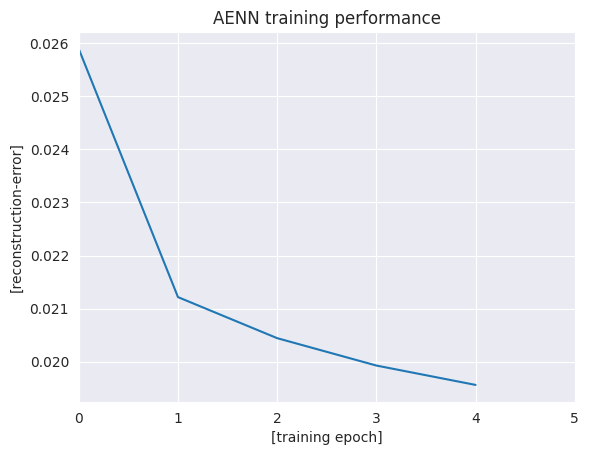

In [ ]:
# plot the training progress
plt.plot(range(0, len(losses)), losses)
plt.xlabel('[training epoch]')
plt.xlim([0, len(losses)])
plt.ylabel('[reconstruction-error]')
#plt.ylim([0.0, 1.0])
plt.title('AENN training performance')

# Evalauting the Autoencoder

In [ ]:
import os
import torch

# restore pretrained model checkpoint
# Correct the file paths to load the appropriate models
encoder_model_name = "/content/sample_data/Anomaly folder/ep_5_encoder_model.pth"  # Changed to encoder model path
decoder_model_name = "/content/sample_data/Anomaly folder/ep_5_decoder_model.pth"

# init training network classes / architectures
encoder_eval = encoder()
decoder_eval = decoder()

# load trained models
encoder_eval.load_state_dict(torch.load(encoder_model_name)) # Removed os.path.join, assuming models are in the same directory
decoder_eval.load_state_dict(torch.load(decoder_model_name)) # Removed os.path.join, assuming models are in the same directory

<All keys matched successfully>

# Pre-Trained model

In [ ]:
# convert encoded transactional data to torch Variable
data = autograd.Variable(torch_dataset)

# set networks in evaluation mode (don't apply dropout)
encoder_eval.eval()
decoder_eval.eval()

# reconstruct encoded transactional data
reconstruction = decoder_eval(encoder_eval(data))

In [ ]:
# determine reconstruction loss - all transactions
reconstruction_loss_all = loss_function(reconstruction, data)

# print reconstruction loss - all transactions
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] collected reconstruction loss of: {:06}/{:06} transactions'.format(now, reconstruction.size()[0], reconstruction.size()[0]))
print('[LOG {}] reconstruction loss: {:.10f}'.format(now, reconstruction_loss_all.item()))

[LOG 20241013-03:53:35] collected reconstruction loss of: 533009/533009 transactions
[LOG 20241013-03:53:35] reconstruction loss: 0.0195641257


# Assessment of individual transactions

In [ ]:
# init binary cross entropy errors
reconstruction_loss_transaction = np.zeros(reconstruction.size()[0])

# iterate over all detailed reconstructions
for i in range(0, reconstruction.size()[0]):

    # determine reconstruction loss - individual transactions
    reconstruction_loss_transaction[i] = loss_function(reconstruction[i], data[i]).item()

    if(i % 100000 == 0):

        ### print conversion summary
        now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
        print('[LOG {}] collected individual reconstruction loss of: {:06}/{:06} transactions'.format(now, i, reconstruction.size()[0]))

[LOG 20241013-03:53:35] collected individual reconstruction loss of: 000000/533009 transactions
[LOG 20241013-03:53:42] collected individual reconstruction loss of: 100000/533009 transactions
[LOG 20241013-03:53:47] collected individual reconstruction loss of: 200000/533009 transactions
[LOG 20241013-03:53:53] collected individual reconstruction loss of: 300000/533009 transactions
[LOG 20241013-03:53:59] collected individual reconstruction loss of: 400000/533009 transactions
[LOG 20241013-03:54:04] collected individual reconstruction loss of: 500000/533009 transactions


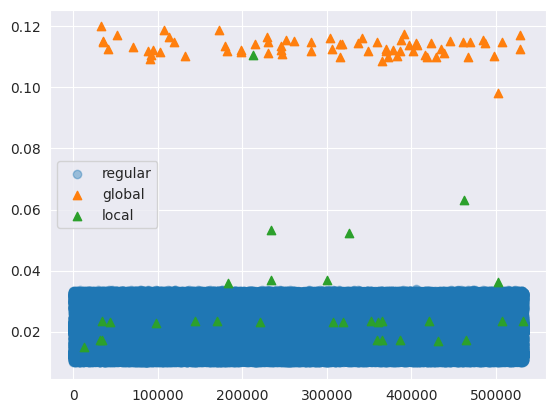

In [ ]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# assign unique id to transactions
plot_data = np.column_stack((np.arange(len(reconstruction_loss_transaction)), reconstruction_loss_transaction))

# obtain regular transactions as well as global and local anomalies
regular_data = plot_data[label == 'regular']
global_outliers = plot_data[label == 'global']
local_outliers = plot_data[label == 'local']

# plot reconstruction error scatter plot
ax.scatter(regular_data[:, 0], regular_data[:, 1], c='C0', alpha=0.4, marker="o", label='regular') # plot regular transactions
ax.scatter(global_outliers[:, 0], global_outliers[:, 1], c='C1', marker="^", label='global') # plot global outliers
ax.scatter(local_outliers[:, 0], local_outliers[:, 1], c='C2', marker="^", label='local') # plot local outliers

# add plot legend of transaction classes
ax.legend(loc='best')

In [ ]:
# append labels to original dataset
ori_dataset['label'] = label

# inspect transactions exhibiting a reconstruction error >= 0.1
ori_dataset[reconstruction_loss_transaction >= 0.1].head()

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
33365,532942,W59,C13,P83,I73,I05,Q99,9.244552e+07,5.958504e+07,global
35691,532967,M07,S42,J81,A14,O49,Z01,9.244553e+07,5.958503e+07,global
35944,532917,J82,Q22,P32,Z74,Y19,K27,9.244553e+07,5.958504e+07,global
41925,532923,T17,R47,D84,F38,I81,D68,9.244552e+07,5.958505e+07,global
52048,532958,Q82,S54,J53,T46,Y42,S06,9.244553e+07,5.958503e+07,global


In [ ]:
# inspect transactions exhibiting a reconstruction error < 0.1 and >= 0.05
ori_dataset[(reconstruction_loss_transaction >= 0.05) & (reconstruction_loss_transaction <= 0.09)]

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
234460,532988,C1,C11,C1,C26,A1,B1,910655.728514,54441.600292,local
326531,533005,C1,C11,C1,C24,A1,B1,910632.886549,54458.195111,local
462643,532982,C1,C11,C1,C21,A1,B1,910648.876816,54437.855551,local


In [ ]:
!pip install scikit-learn==1.2.2

Accuracy: 0.9941839740342583


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      global       0.01      1.00      0.03         8
       local       0.00      0.00      0.00         8
     regular       1.00      0.99      1.00    106586

    accuracy                           0.99    106602
   macro avg       0.34      0.66      0.34    106602
weighted avg       1.00      0.99      1.00    106602



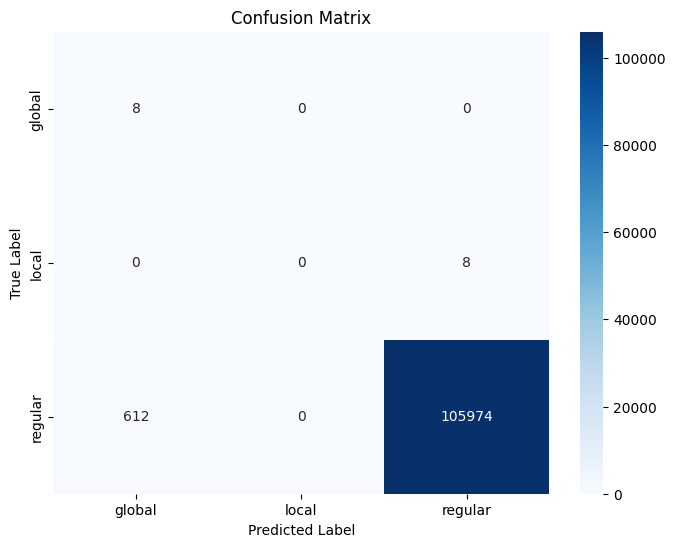

Data has more than 2 features. Dimensionality reduction is needed for visualization.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier  # Using SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Load the dataset
ori_subset_transformed = pd.read_csv('Anomaly_dataset.csv')
label = ori_subset_transformed['label']
ori_subset_transformed = ori_subset_transformed.drop('label', axis=1)

# Create a OneHotEncoder object
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit the encoder on the categorical features and transform them
categorical_features = ori_subset_transformed.select_dtypes(include=['object']).columns
encoded_features = encoder.fit_transform(ori_subset_transformed[categorical_features])

# Create a new DataFrame with encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))

# Concatenate the encoded features with the numerical features
numerical_features = ori_subset_transformed.select_dtypes(exclude=['object']).columns
X = pd.concat([ori_subset_transformed[numerical_features], encoded_df], axis=1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=0.2, random_state=42)

# Create the SGDClassifier (equivalent to linear SVM)
svm_classifier = SGDClassifier(loss='hinge', alpha=0.0001, max_iter=1000, random_state=42)

# Partial fitting (in batches)
chunk_size = 10000  # Adjust chunk size as needed
for i in range(0, X_train.shape[0], chunk_size):
    svm_classifier.partial_fit(X_train[i:i + chunk_size], y_train[i:i + chunk_size], classes=np.unique(y_train))

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

# Visualize the results using a confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['global', 'local', 'regular'],
            yticklabels=['global', 'local', 'regular'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Visualize decision boundaries (if data has 2 features)
if X.shape[1] == 2:
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    Z = svm_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=label, cmap=plt.cm.brg)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("SVM Decision Boundaries")
    plt.show()
else:
    print("Data has more than 2 features. Dimensionality reduction is needed for visualization.")